In [2]:
!pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.0/413.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.1 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.33
    Uninstalling langchain-core-0.3.33:
      Successfully uninstalled langchain-core-0.3.33


In [3]:
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.4 MB/s eta 0:00:00


In [4]:
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00


In [12]:
!apt-get install graphviz graphviz-dev # Install Graphviz using apt
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 19 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://a

### GRAPH 1 ( EMAIL CATEROGY  1 -PAYMENT STATUS ENQUIRY)

In [ ]:
import time
import json
import pandas as pd
from typing import List, Annotated, TypedDict, Sequence
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables import RunnableConfig


# -----------------------------------------------------------------------------
# Unified State Definition (used by parent, Graph 1 and Graph 2)
# -----------------------------------------------------------------------------
class AgentState(TypedDict):
    category: str      # Initially holds raw email text; later updated with classification
    invoice_id: str
    po_number: str
    messages: Annotated[List[BaseMessage], add_messages]

# =============================================================================
# GRAPH 1: Past Due Enquiry Subgraph
# =============================================================================

# --- Tools for Graph 1 (Original implementations) ---

@tool
def imagenow_tool(invoice_id: str):
    """Check payment status in Imagenow from an Excel file."""
    imagenow_file_path = "/content/image_now_modified.xlsx"  # Update with your actual path
    imagenow_df = pd.read_excel(imagenow_file_path)
    invoice_data = imagenow_df[imagenow_df["Invoice Number"] == invoice_id]
    if not invoice_data.empty:
        payment_status = invoice_data.iloc[0]["Status"]
        return {"status": payment_status}
    else:
        return {"error": f"Invoice {invoice_id} not found."}

@tool
def lawson_tool(invoice_id: str):
    """Fetch payment details from Lawson from an Excel file."""
    lawson_file_path = "/content/lawson_modified.xlsx"  # Update with your actual path
    lawson_df = pd.read_excel(lawson_file_path)
    invoice_data = lawson_df[lawson_df["Invoice ID"] == invoice_id]
    if not invoice_data.empty:
        payment_method = invoice_data.iloc[0]["Payment Method"]
        payment_date = invoice_data.iloc[0]["Payment Date"]
        exception_status = invoice_data.iloc[0]["Exception Status"]
        return {
            "payment_method": payment_method,
            "payment_date": str(payment_date),  # Convert to string if necessary
            "exception_status": exception_status,
        }
    else:
        return {"error": f"Invoice {invoice_id} not found."}

@tool
def ivalua_tool(invoice_id: str):
    """Check transmission status in Ivalua from an Excel file."""
    ivalua_file_path = "/content/ivalua_dataset.xlsx"  # Update with your actual path
    ivalua_df = pd.read_excel(ivalua_file_path)
    invoice_row = ivalua_df[ivalua_df["Invoice Number"] == invoice_id]
    if not invoice_row.empty:
        transmission_status = invoice_row.iloc[0]["Transmission Status"]
        exception_status = invoice_row.iloc[0]["Exception status"]
        return {
            "transmission_status": transmission_status,
            "exception_status": exception_status
        }
    else:
        return {"error": f"Invoice {invoice_id} not found in Ivalua."}

@tool
def email_tool(recipient: str, message: str):
    """Send an email to the vendor or team."""
    print(f"Graph1 - email_tool: Sending email to {recipient}")
    # Here, insert your actual email-sending logic if needed.
    return {"email_status": "Sent"}

tools_graph1 = [imagenow_tool, lawson_tool, ivalua_tool, email_tool]
tools_by_name_graph1 = {tool.name: tool for tool in tools_graph1}

# --- Graph 1 Nodes ---
def call_model(state: AgentState, config: RunnableConfig) -> AgentState:
    if not state["messages"]:
        hm = HumanMessage(content=f"Check the payment status of invoice {state['invoice_id']}. PO number is {state['po_number']}")
        state["messages"].append(hm)
        print("Graph1 - call_model: Added HumanMessage:", hm.content)

    steps_prompt = """
1. Check the payment status in Imagenow using the invoice ID.
2. If the status is "Paid":
   - Fetch payment details (method and date) from Lawson.
   - Respond to the vendor with the payment details.
   - Update the notes in Imagenow.
3. If the status is "Not Paid":
   - Determine whether the PO is a 10-digit or 11-digit number.
   - For an 11-digit PO:
       - Check transmission status in Ivalua.
       - If not transmitted, notify the appropriate person and update the notes.
       - If transmitted, check exception status in Lawson.
   - For a 10-digit PO:
       - Check exception status in Lawson.
       - Notify the appropriate person based on the exception status.
4. At each step, use the appropriate tool and reason about the next action based on the tool's result.
"""
    system_prompt = SystemMessage(content=steps_prompt)
    model1 = ChatOpenAI(model="gpt-4", temperature=0).bind_tools(tools_graph1)
    response = model1.invoke([system_prompt] + state["messages"], config)
    state["messages"].append(response)
    print("Graph1 - call_model: After LLM invocation, messages:")
    for msg in state["messages"]:
        print("  ", msg.content)
    return state

def tool_node(state: AgentState) -> AgentState:
    outputs = []
    last_msg = state["messages"][-1]
    print("Graph1 - tool_node: Processing tool_calls from message:", last_msg.content)
    for tool_call in last_msg.tool_calls:
        tool_func = tools_by_name_graph1[tool_call["name"]]
        tool_result = tool_func(**tool_call["args"])
        for key, value in tool_result.items():
            if hasattr(value, "isoformat"):
                tool_result[key] = value.isoformat()
        tm = ToolMessage(
            content=json.dumps(tool_result),
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        )
        outputs.append(tm)
        print("Graph1 - tool_node: Generated ToolMessage for", tool_call["name"])
    state["messages"].extend(outputs)
    print("Graph1 - tool_node: Updated messages:")
    for msg in state["messages"]:
        print("  ", msg.content)
    return state

def should_continue(state: AgentState):
    last_msg = state["messages"][-1]
    if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
        return "tools"
    return "end"

graph1_builder = StateGraph(AgentState)
graph1_builder.add_node("agent", call_model)
graph1_builder.add_node("tools", tool_node)
graph1_builder.set_entry_point("agent")
graph1_builder.add_conditional_edges("agent", should_continue, {"tools": "tools", "end": END})
graph1_builder.add_edge("tools", "agent")
graph1 = graph1_builder.compile()




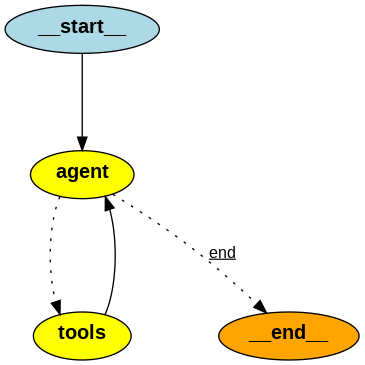

In [ ]:
from IPython.display import Image

# Assuming `graph.get_graph()` provides a graph object and `.draw_png()` generates a PNG image
# Visualize the graph in a Jupyter notebook
Image(graph1.get_graph().draw_png())

### GRAPH 2 (PO inquiry)

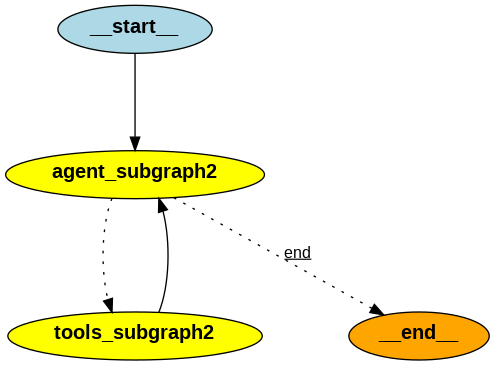

In [ ]:
from IPython.display import Image

# Assuming `graph.get_graph()` provides a graph object and `.draw_png()` generates a PNG image
start_time = time.time()
# Visualize the graph in a Jupyter notebook
Image(graph2.get_graph().draw_png())

In [ ]:


# =============================================================================
# PARENT GRAPH (Combined Graph)
# =============================================================================

def categorize_email(state: AgentState) -> AgentState:
    model = ChatOpenAI(model="gpt-4", temperature=0)
    system_prompt = SystemMessage(
        content="Classify the email into one of the categories: 'Past Due Enquiry', 'PO Invoice for Processing'."
    )
    # Wrap the raw email text as a HumanMessage.
    email_message = HumanMessage(content=state["category"])
    messages = [system_prompt, email_message]
    result = model.invoke(messages)
    result_text = result.content.strip()
    if ((result_text.startswith("'") and result_text.endswith("'")) or
        (result_text.startswith('"') and result_text.endswith('"'))):
        result_text = result_text[1:-1].strip()
    state["category"] = result_text
    print("Parent - After categorize_email, state:", state)
    return state

def categorize_decision(state: AgentState):
    if state["category"] == "Past Due Enquiry":
        return "graph1"
    elif state["category"] == "PO Invoice for Processing":
        return "graph2"
    else:
        return END

parent_builder = StateGraph(AgentState)
parent_builder.add_node("categorize_email", categorize_email)
# Add the compiled subgraphs directly.
parent_builder.add_node("graph1", graph1)
parent_builder.add_node("graph2", graph2)
parent_builder.set_entry_point("categorize_email")
parent_builder.add_conditional_edges("categorize_email", categorize_decision, {
    "graph1": "graph1",
    "graph2": "graph2",
    END: END
})
parent_graph = parent_builder.compile()

# =============================================================================


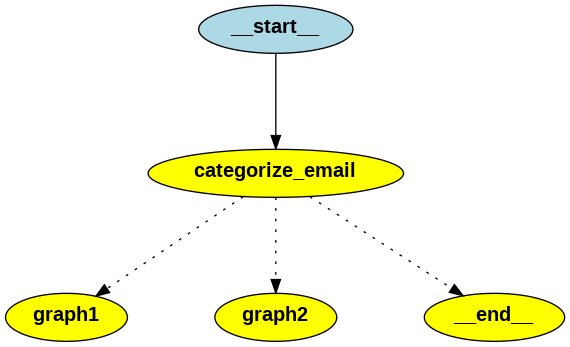

In [ ]:
from IPython.display import Image

# Assuming `graph.get_graph()` provides a graph object and `.draw_png()` generates a PNG image
# Visualize the graph in a Jupyter notebook
Image(parent_graph.get_graph().draw_png())

In [ ]:
# 3. Run the Combined Parent Graph:
print("\n==== Running Combined Parent Graph ====")
initial_state_parent: AgentState = {
    "category": "Check the payment status of invoice INV-0003. PO number is 77649657916",
    "invoice_id": "INV-0003",
    "po_number": "77649657916",
    "messages": []
}
final_state_parent = parent_graph.invoke(initial_state_parent)
print("Final Parent State:")
print(final_state_parent)


==== Running Combined Parent Graph ====
Parent - After categorize_email, state: {'category': 'Past Due Enquiry', 'invoice_id': 'INV-0003', 'po_number': '77649657916', 'messages': []}
Graph1 - call_model: Added HumanMessage: Check the payment status of invoice INV-0003. PO number is 77649657916
Graph1 - call_model: After LLM invocation, messages:
   Check the payment status of invoice INV-0003. PO number is 77649657916
   
Graph1 - tool_node: Processing tool_calls from message: 
Graph1 - tool_node: Generated ToolMessage for imagenow_tool
Graph1 - tool_node: Updated messages:
   Check the payment status of invoice INV-0003. PO number is 77649657916
   
   {"status": "Not Paid"}
Graph1 - call_model: After LLM invocation, messages:
   Check the payment status of invoice INV-0003. PO number is 77649657916
   
   {"status": "Not Paid"}
   The PO number is an 11-digit number. Let's check the transmission status in Ivalua.
Graph1 - tool_node: Processing tool_calls from message: The PO number 

In [22]:
import time
import json
import pandas as pd
from typing import List, Annotated, TypedDict, Sequence
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables import RunnableConfig

# -----------------------------------------------------------------------------
# Tool Decorator (if not provided by your framework)
# -----------------------------------------------------------------------------
def tool(func):
    func.name = func.__name__
    return func

# -----------------------------------------------------------------------------
# Unified State Definition (used by parent, Graph 1 and Graph 2)
# -----------------------------------------------------------------------------
class AgentState(TypedDict):
    category: str      # Holds raw email text; later updated with classification
    invoice_id: str
    po_number: str
    messages: Annotated[List[BaseMessage], add_messages]

# =============================================================================
# GRAPH 1: Past Due Enquiry Subgraph
# =============================================================================

# --- Tools for Graph 1 (Original implementations) ---

@tool
def imagenow_tool(invoice_id: str):
    """Check payment status in Imagenow from an Excel file."""
    imagenow_file_path = "/content/image_now_modified.xlsx"  # Replace with your actual path
    imagenow_df = pd.read_excel(imagenow_file_path)
    invoice_data = imagenow_df[imagenow_df["Invoice Number"] == invoice_id]
    if not invoice_data.empty:
        payment_status = invoice_data.iloc[0]["Status"]
        return {"status": payment_status}
    else:
        return {"error": f"Invoice {invoice_id} not found."}

@tool
def lawson_tool(invoice_id: str):
    """Fetch payment details from Lawson from an Excel file."""
    lawson_file_path = "/content/lawson_modified.xlsx"  # Replace with your actual path
    lawson_df = pd.read_excel(lawson_file_path)
    invoice_data = lawson_df[lawson_df["Invoice ID"] == invoice_id]
    if not invoice_data.empty:
        payment_method = invoice_data.iloc[0]["Payment Method"]
        payment_date = invoice_data.iloc[0]["Payment Date"]
        exception_status = invoice_data.iloc[0]["Exception Status"]
        return {
            "payment_method": payment_method,
            "payment_date": str(payment_date),
            "exception_status": exception_status,
        }
    else:
        return {"error": f"Invoice {invoice_id} not found."}

@tool
def ivalua_tool(invoice_id: str):
    """Check transmission status in Ivalua from an Excel file."""
    ivalua_file_path = "/content/ivalua_dataset.xlsx"  # Replace with your actual path
    ivalua_df = pd.read_excel(ivalua_file_path)
    invoice_row = ivalua_df[ivalua_df["Invoice Number"] == invoice_id]
    if not invoice_row.empty:
        transmission_status = invoice_row.iloc[0]["Transmission Status"]
        exception_status = invoice_row.iloc[0]["Exception status"]
        return {
            "transmission_status": transmission_status,
            "exception_status": exception_status
        }
    else:
        return {"error": f"Invoice {invoice_id} not found in Ivalua."}

@tool
def email_tool(recipient: str, message: str):
    """Send an email to the vendor or team."""
    print(f"Graph1 - email_tool: Sending email to {recipient}")
    return {"email_status": "Sent"}

tools_graph1 = [imagenow_tool, lawson_tool, ivalua_tool, email_tool]
tools_by_name_graph1 = {tool.name: tool for tool in tools_graph1}

# --- Graph 1 Nodes ---
def call_model(state: AgentState, config: RunnableConfig) -> AgentState:
    # Since the initial HumanMessage is already provided in state["messages"],
    # we do not add another one.
    steps_prompt = """
1. Check the payment status in Imagenow using the invoice ID.
2. If the status is "Paid":
   - Fetch payment details (method and date) from Lawson.
   - Respond to the vendor with the payment details.
   - Update the notes in Imagenow.
3. If the status is "Not Paid":
   - Determine whether the PO is a 10-digit or 11-digit number.
   - For an 11-digit PO:
       - Check transmission status in Ivalua.
       - If not transmitted, notify the appropriate person and update the notes.
       - If transmitted, check exception status in Lawson.
   - For a 10-digit PO:
       - Check exception status in Lawson.
       - Notify the appropriate person based on the exception status.
4. At each step, use the appropriate tool and reason about the next action based on the tool's result.
"""

    system_prompt = SystemMessage(content=steps_prompt)
    model1 = ChatOpenAI(model="gpt-4", temperature=0).bind_tools(tools_graph1)
    response = model1.invoke([system_prompt] + state["messages"], config)
    state["messages"].append(response)
    print("Graph1 - call_model: After LLM invocation, messages:")
    for msg in state["messages"]:
        print("  ", msg.content)
    return state

def tool_node(state: AgentState) -> AgentState:
    outputs = []
    last_msg = state["messages"][-1]
    print("Graph1 - tool_node: Processing tool_calls from message:", last_msg.content)
    for tool_call in last_msg.tool_calls:
        tool_func = tools_by_name_graph1[tool_call["name"]]
        tool_result = tool_func(**tool_call["args"])
        for key, value in tool_result.items():
            if hasattr(value, "isoformat"):
                tool_result[key] = value.isoformat()
        tm = ToolMessage(
            content=json.dumps(tool_result),
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        )
        outputs.append(tm)
        print("Graph1 - tool_node: Generated ToolMessage for", tool_call["name"])
    state["messages"].extend(outputs)
    print("Graph1 - tool_node: Updated messages:")
    for msg in state["messages"]:
        print("  ", msg.content)
    return state

def should_continue(state: AgentState):
    last_msg = state["messages"][-1]
    if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
        return "tools"
    return "end"

graph1_builder = StateGraph(AgentState)
graph1_builder.add_node("agent", call_model)
graph1_builder.add_node("tools", tool_node)
graph1_builder.set_entry_point("agent")
graph1_builder.add_conditional_edges("agent", should_continue, {"tools": "tools", "end": END})
graph1_builder.add_edge("tools", "agent")
graph1 = graph1_builder.compile()

# =============================================================================
# GRAPH 2: PO Invoice Processing Subgraph
# =============================================================================

# --- Tools for Graph 2 (Original implementations) ---
@tool
def imagenow_tool_subgraph2(invoice_id: str):
    """Check if invoice is present in Imagenow from an Excel file for Graph2."""
    imagenow_file_path = "/content/image_now_modified.xlsx"  # Replace with your actual path
    imagenow_df = pd.read_excel(imagenow_file_path)
    invoice_data = imagenow_df[imagenow_df["Invoice Number"] == invoice_id]
    if not invoice_data.empty:
        queue = invoice_data.iloc[0].get("Queue", "Not Assigned")
        return {"status": "Present", "queue": queue}
    else:
        return {"status": "Not Present"}

@tool
def email_tool_subgraph2(recipient: str, message: str):
    """Send an email for Graph2."""
    print(f"Graph2 - email_tool_subgraph2: Sending email to {recipient}")
    return {"email_status": "Sent"}

tools_graph2 = [imagenow_tool_subgraph2, email_tool_subgraph2]
tools_by_name_graph2 = {tool.name: tool for tool in tools_graph2}

# --- Graph 2 Nodes ---
def call_model_subgraph2(state: AgentState, config: RunnableConfig) -> AgentState:
    # Assume the initial HumanMessage is already provided in state["messages"].
    steps_prompt_subgraph2 = """
You are an AI orchestrator for the PO Invoice Processing workflow.
1. Check if the invoice is present in Imagenow using the invoice ID.
2. If not present, forward an email to the processing team.
3. If present, check the queue and decide on the next action.
Decide which tool to call next.
"""
    system_prompt = SystemMessage(content=steps_prompt_subgraph2)
    model2 = ChatOpenAI(model="gpt-4", temperature=0).bind_tools(tools_graph2)
    response = model2.invoke([system_prompt] + state["messages"], config)
    state["messages"].append(response)
    print("Graph2 - call_model_subgraph2: After LLM invocation, messages:")
    for msg in state["messages"]:
        print("  ", msg.content)
    return state

def tool_node_subgraph2(state: AgentState) -> AgentState:
    outputs = []
    last_msg = state["messages"][-1]
    print("Graph2 - tool_node_subgraph2: Processing tool_calls from message:", last_msg.content)
    for tool_call in last_msg.tool_calls:
        tool_func = tools_by_name_graph2[tool_call["name"]]
        tool_result = tool_func(**tool_call["args"])
        for key, value in tool_result.items():
            if hasattr(value, "isoformat"):
                tool_result[key] = value.isoformat()
        tm = ToolMessage(
            content=json.dumps(tool_result, indent=2),
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        )
        outputs.append(tm)
        print("Graph2 - tool_node_subgraph2: Generated ToolMessage for", tool_call["name"])
    state["messages"].extend(outputs)
    print("Graph2 - tool_node_subgraph2: Updated messages:")
    for msg in state["messages"]:
        print("  ", msg.content)
    return state

def should_continue_subgraph2(state: AgentState):
    last_msg = state["messages"][-1]
    if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
        return "tools_subgraph2"
    return "end"

graph2_builder = StateGraph(AgentState)
graph2_builder.add_node("agent_subgraph2", call_model_subgraph2)
graph2_builder.add_node("tools_subgraph2", tool_node_subgraph2)
graph2_builder.set_entry_point("agent_subgraph2")
graph2_builder.add_conditional_edges("agent_subgraph2", should_continue_subgraph2, {"tools_subgraph2": "tools_subgraph2", "end": END})
graph2_builder.add_edge("tools_subgraph2", "agent_subgraph2")
graph2 = graph2_builder.compile()

# =============================================================================
# PARENT GRAPH (Combined Graph)
# =============================================================================

def categorize_email(state: AgentState) -> AgentState:
    model = ChatOpenAI(model="gpt-4", temperature=0)
    system_prompt = SystemMessage(
        content="Classify the email into one of the categories: 'Past Due Enquiry', 'PO Invoice for Processing'."
    )
    # Wrap the raw email text as a HumanMessage.
    email_message = HumanMessage(content=state["category"])
    messages = [system_prompt, email_message]
    result = model.invoke(messages)
    result_text = result.content.strip()
    if ((result_text.startswith("'") and result_text.endswith("'")) or
        (result_text.startswith('"') and result_text.endswith('"'))):
        result_text = result_text[1:-1].strip()
    state["category"] = result_text
    print("Parent - After categorize_email, state:", state)
    return state

def categorize_decision(state: AgentState):
    if state["category"] == "Past Due Enquiry":
        return "graph1"
    elif state["category"] == "PO Invoice for Processing":
        return "graph2"+
    else:
        return END

parent_builder = StateGraph(AgentState)
parent_builder.add_node("categorize_email", categorize_email)
# Add the compiled subgraphs directly.
parent_builder.add_node("graph1", graph1)
parent_builder.add_node("graph2", graph2)
parent_builder.set_entry_point("categorize_email")
parent_builder.add_conditional_edges("categorize_email", categorize_decision, {
    "graph1": "graph1",
    "graph2": "graph2",
    END: END
})
parent_graph = parent_builder.compile()

# =============================================================================
# EXECUTION
# =============================================================================


# 3. Run the Combined Parent Graph:
print("\n==== Running Combined Parent Graph ====")
initial_state_parent: AgentState = {
    "category": "Check invoice status in Imagenow for INV-0003 and process if required.",
    "invoice_id": "INV-0003",
    "po_number": "INV-77649657916",
    "messages": [HumanMessage(content="Check invoice status in Imagenow for INV-0003 and process if required.")]
}
final_state_parent = parent_graph.invoke(initial_state_parent)
print("Final Parent State:")
print(final_state_parent)




==== Running Combined Parent Graph ====
Parent - After categorize_email, state: {'category': 'PO Invoice for Processing', 'invoice_id': 'INV-0003', 'po_number': 'INV-77649657916', 'messages': [HumanMessage(content='Check invoice status in Imagenow for INV-0003 and process if required.', additional_kwargs={}, response_metadata={}, id='3fed18a4-9b3c-462b-b78e-c5e0b5d37196')]}
Graph2 - call_model_subgraph2: After LLM invocation, messages:
   Check invoice status in Imagenow for INV-0003 and process if required.
   
Graph2 - tool_node_subgraph2: Processing tool_calls from message: 
Graph2 - tool_node_subgraph2: Generated ToolMessage for imagenow_tool_subgraph2
Graph2 - tool_node_subgraph2: Updated messages:
   Check invoice status in Imagenow for INV-0003 and process if required.
   
   {
  "status": "Present",
  "queue": "Nil"
}
Graph2 - call_model_subgraph2: After LLM invocation, messages:
   Check invoice status in Imagenow for INV-0003 and process if required.
   
   {
  "status": "Pr

In [23]:
### Invoice is Paid
# =============================================================================
# EXECUTION
# =============================================================================
# Run the Combined Parent Graph:
print("\n==== Running Combined Parent Graph ====")
initial_state_parent: AgentState = {
    "category": "Check the payment status of invoice INV-0001.PO number is 47687632524",
    "invoice_id": "INV-0003",
    "po_number": "47687632524",
    "messages": [HumanMessage(content="Check the payment status of invoice INV-0001.PO number is 47687632524.")]
}
final_state_parent = parent_graph.invoke(initial_state_parent)
print("Final Parent State:")
print(final_state_parent)



==== Running Combined Parent Graph ====
Parent - After categorize_email, state: {'category': 'Past Due Enquiry', 'invoice_id': 'INV-0003', 'po_number': '47687632524', 'messages': [HumanMessage(content='Check the payment status of invoice INV-0001.PO number is 47687632524.', additional_kwargs={}, response_metadata={}, id='61726134-40a1-418f-bf3b-3e8cb24ab8b4')]}
Graph1 - call_model: After LLM invocation, messages:
   Check the payment status of invoice INV-0001.PO number is 47687632524.
   
Graph1 - tool_node: Processing tool_calls from message: 
Graph1 - tool_node: Generated ToolMessage for imagenow_tool
Graph1 - tool_node: Updated messages:
   Check the payment status of invoice INV-0001.PO number is 47687632524.
   
   {"status": "Paid"}
Graph1 - call_model: After LLM invocation, messages:
   Check the payment status of invoice INV-0001.PO number is 47687632524.
   
   {"status": "Paid"}
   
Graph1 - tool_node: Processing tool_calls from message: 
Graph1 - tool_node: Generated ToolM

In [24]:
### Invoice is Not Paid and 10 digit PO
# =============================================================================
# EXECUTION
# =============================================================================
# Run the Combined Parent Graph:
print("\n==== Running Combined Parent Graph ====")
initial_state_parent: AgentState = {
    "category": "Check the payment status of invoice INV-0002.PO number is 8752760620",
    "invoice_id": "INV-0002",
    "po_number": "8752760620",
    "messages": [HumanMessage(content="Check the payment status of invoice INV-0002.PO number is 8752760620.")]
}
final_state_parent = parent_graph.invoke(initial_state_parent)
print("Final Parent State:")
print(final_state_parent)


==== Running Combined Parent Graph ====
Parent - After categorize_email, state: {'category': 'Past Due Enquiry', 'invoice_id': 'INV-0002', 'po_number': '8752760620', 'messages': [HumanMessage(content='Check the payment status of invoice INV-0002.PO number is 8752760620.', additional_kwargs={}, response_metadata={}, id='ee311006-f7f9-4c43-8d95-4092c1ddfc8d')]}
Graph1 - call_model: After LLM invocation, messages:
   Check the payment status of invoice INV-0002.PO number is 8752760620.
   
Graph1 - tool_node: Processing tool_calls from message: 
Graph1 - tool_node: Generated ToolMessage for imagenow_tool
Graph1 - tool_node: Updated messages:
   Check the payment status of invoice INV-0002.PO number is 8752760620.
   
   {"status": "Not Paid"}
Graph1 - call_model: After LLM invocation, messages:
   Check the payment status of invoice INV-0002.PO number is 8752760620.
   
   {"status": "Not Paid"}
   The PO number is a 10-digit number. Let's check the exception status in Lawson.
Graph1 - t

In [21]:
11 Digit Po Paid
# =============================================================================
# EXECUTION
# =============================================================================
# Run the Combined Parent Graph:
print("\n==== Running Combined Parent Graph ====")
initial_state_parent: AgentState = {
    "category": "Check the payment status of invoice INV-0003.PO number is 77649657916.",
    "invoice_id": "INV-0003",
    "po_number": "INV-77649657916",
    "messages": [HumanMessage(content="Check the payment status of invoice INV-0003.PO number is 77649657916.")]
}
final_state_parent = parent_graph.invoke(initial_state_parent)
print("Final Parent State:")
print(final_state_parent)




==== Running Combined Parent Graph ====
Parent - After categorize_email, state: {'category': 'Past Due Enquiry', 'invoice_id': 'INV-0003', 'po_number': 'INV-77649657916', 'messages': [HumanMessage(content='Check the payment status of invoice INV-0003.PO number is 77649657916.', additional_kwargs={}, response_metadata={}, id='3cbdd214-ce59-4910-8a15-859c89d7ef84')]}
Graph1 - call_model: After LLM invocation, messages:
   Check the payment status of invoice INV-0003.PO number is 77649657916.
   
Graph1 - tool_node: Processing tool_calls from message: 
Graph1 - tool_node: Generated ToolMessage for imagenow_tool
Graph1 - tool_node: Updated messages:
   Check the payment status of invoice INV-0003.PO number is 77649657916.
   
   {"status": "Not Paid"}
Graph1 - call_model: After LLM invocation, messages:
   Check the payment status of invoice INV-0003.PO number is 77649657916.
   
   {"status": "Not Paid"}
   The PO number 77649657916 is an 11-digit number. Let's check the transmission sta